In [27]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches # Needed for custom legend

transgene_name = "Rosa26_SBP1"

In [28]:
# Define file paths
transgene_adata_path = "counts_trans/Emx1_Mut.h5ad"
annotated_merged_adata_path = "combine_data/results_from_raw/final_annotation/merged_raw_final_annotated_simple_mapmycells.h5ad"
output_adata_path = "counts_trans/Emx1_Mut_annotated_final.h5ad"

print(f"Transgene AnnData path: {transgene_adata_path}")
print(f"Annotated merged AnnData path: {annotated_merged_adata_path}")
print(f"Output AnnData path: {output_adata_path}")

Transgene AnnData path: counts_trans/Emx1_Mut.h5ad
Annotated merged AnnData path: combine_data/results_from_raw/final_annotation/merged_raw_final_annotated_simple_mapmycells.h5ad
Output AnnData path: counts_trans/Emx1_Mut_annotated_final.h5ad


In [29]:
# Load AnnData objects
print("\nLoading AnnData objects...")
try:
    adata_transgene = sc.read_h5ad(transgene_adata_path)
    print(f"Loaded adata_transgene with shape: {adata_transgene.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {transgene_adata_path}")
    exit()

try:
    adata_annotated_full = sc.read_h5ad(annotated_merged_adata_path)
    print(f"Loaded adata_annotated_full with shape: {adata_annotated_full.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {annotated_merged_adata_path}")
    exit()


Loading AnnData objects...
Loaded adata_transgene with shape: (5936, 25126)
Loaded adata_annotated_full with shape: (22760, 28293)


In [30]:
# Filter annotations for the "Emx1_Mut" sample
print("\nFiltering annotations for 'Emx1_Mut' sample...")
if 'sample' not in adata_annotated_full.obs.columns:
    print("ERROR: 'sample' column not found in adata_annotated_full.obs")
    exit()

adata_annotated_emx1_mut = adata_annotated_full[adata_annotated_full.obs['sample'] == 'Emx1_Mut'].copy()
print(f"Shape of adata_annotated_emx1_mut after sample filtering: {adata_annotated_emx1_mut.shape}")

if adata_annotated_emx1_mut.n_obs == 0:
    print("ERROR: No cells found for sample 'Emx1_Mut'. Check the sample name.")
    exit()


Filtering annotations for 'Emx1_Mut' sample...
Shape of adata_annotated_emx1_mut after sample filtering: (5001, 28293)


In [31]:
# Prepare barcodes for mapping
print("\nPreparing barcodes for mapping...")
# The obs_names in adata_transgene are original (e.g., CELLX-1).
# The obs_names in adata_annotated_emx1_mut are suffixed (e.g., CELLX-1-1).
# Create a new column in adata_annotated_emx1_mut.obs called original_barcode

adata_annotated_emx1_mut.obs_names = adata_annotated_emx1_mut.obs_names.astype(str)
adata_transgene.obs_names = adata_transgene.obs_names.astype(str)

adata_annotated_emx1_mut.obs['original_barcode'] = adata_annotated_emx1_mut.obs_names.str.replace(r'-\d+$', '', regex=True)

print("Head of adata_annotated_emx1_mut.obs[['original_barcode']]:")
print(adata_annotated_emx1_mut.obs[['original_barcode']].head())


Preparing barcodes for mapping...
Head of adata_annotated_emx1_mut.obs[['original_barcode']]:
                        original_barcode
AAACAGCCATCCAGGT-1-1  AAACAGCCATCCAGGT-1
AAACAGCCATGCAACC-1-1  AAACAGCCATGCAACC-1
AAACATGCACCTGTAA-1-1  AAACATGCACCTGTAA-1
AAACATGCAGCTACGT-1-1  AAACATGCAGCTACGT-1
AAACCAACAAGGATTA-1-1  AAACCAACAAGGATTA-1


In [32]:
# Extract and map annotations
print("\nExtracting and mapping annotations...")
annotation_cols = ['cell_type', 'mapmycells_first_layer', 'mapmycells_second_layer']
print(f"Annotation columns to transfer: {annotation_cols}")

# Check if columns exist in the filtered annotated data
missing_cols = [col for col in annotation_cols if col not in adata_annotated_emx1_mut.obs]
if missing_cols:
    print(f"WARNING: Annotation columns missing in adata_annotated_emx1_mut.obs: {missing_cols}")
    annotation_cols = [col for col in annotation_cols if col in adata_annotated_emx1_mut.obs]
    print(f"Using available annotation columns: {annotation_cols}")

if not annotation_cols:
    print("ERROR: No annotation columns available to transfer. Exiting.")
    exit()


Extracting and mapping annotations...
Annotation columns to transfer: ['cell_type', 'mapmycells_first_layer', 'mapmycells_second_layer']


In [33]:
if 'original_barcode' not in adata_annotated_emx1_mut.obs:
     print("ERROR: 'original_barcode' column not created correctly.")
     exit()

annotations_to_add_df = adata_annotated_emx1_mut.obs[['original_barcode'] + annotation_cols].copy()
annotations_to_add_df.head()

,original_barcode,cell_type,mapmycells_first_layer,mapmycells_second_layer
AAACAGCCATCCAGGT-1-1,AAACAGCCATCCAGGT-1,Oligo,Oligo,NFOL
AAACAGCCATGCAACC-1-1,AAACAGCCATGCAACC-1,Oligo,Oligo,MOL
AAACATGCACCTGTAA-1-1,AAACATGCACCTGTAA-1,DG,ExN,immature GC
AAACATGCAGCTACGT-1-1,AAACATGCAGCTACGT-1,ExN,ExN,neuroblast
AAACCAACAAGGATTA-1-1,AAACCAACAAGGATTA-1,GABA,GABA,PV


In [34]:
# Set original_barcode as the index for mapping
annotations_to_add_df.set_index('original_barcode', inplace=True)
if annotations_to_add_df.index.has_duplicates:
    print(f"Warning: Found {annotations_to_add_df.index.duplicated().sum()} duplicate barcodes after removing suffix. Keeping first annotation found for each.")
    annotations_to_add_df = annotations_to_add_df[~annotations_to_add_df.index.duplicated(keep='first')]

annotations_to_add_df.head()

,cell_type,mapmycells_first_layer,mapmycells_second_layer
original_barcode,,,
AAACAGCCATCCAGGT-1,Oligo,Oligo,NFOL
AAACAGCCATGCAACC-1,Oligo,Oligo,MOL
AAACATGCACCTGTAA-1,DG,ExN,immature GC
AAACATGCAGCTACGT-1,ExN,ExN,neuroblast
AAACCAACAAGGATTA-1,GABA,GABA,PV


In [35]:
# Map annotations to adata_transgene.obs
for col in annotation_cols:
    adata_transgene.obs[col] = pd.NA # Use pandas NA for categorical potential

# Perform the mapping
for col in annotation_cols:
    print(f"Mapping column: {col}")
    adata_transgene.obs[col] = adata_transgene.obs_names.map(annotations_to_add_df[col])
    if annotations_to_add_df[col].dtype == 'category':
         adata_transgene.obs[col] = adata_transgene.obs[col].astype('category')

Mapping column: cell_type
Mapping column: mapmycells_first_layer
Mapping column: mapmycells_second_layer


In [36]:
# Verify the merge
print("\nVerifying the merge...")
print("Head of newly added columns in adata_transgene.obs:")
adata_transgene.obs[annotation_cols].head()


Verifying the merge...
Head of newly added columns in adata_transgene.obs:


,cell_type,mapmycells_first_layer,mapmycells_second_layer
AAACAGCCATCCAGGT-1,Oligo,Oligo,NFOL
AAACAGCCATGCAACC-1,Oligo,Oligo,MOL
AAACATGCACCTGTAA-1,DG,ExN,immature GC
AAACATGCAGCTACGT-1,ExN,ExN,neuroblast
AAACCAACAAGGATTA-1,GABA,GABA,PV


In [37]:
total_cells_transgene = adata_transgene.n_obs
cells_in_annotated_qc = adata_annotated_emx1_mut.n_obs

print(f"\nTotal cells in adata_transgene: {total_cells_transgene}")
print(f"Total cells in adata_annotated_emx1_mut (after QC): {cells_in_annotated_qc}")
print(f"Number of unique barcodes in mapping table: {len(annotations_to_add_df)}")


Total cells in adata_transgene: 5936
Total cells in adata_annotated_emx1_mut (after QC): 5001
Number of unique barcodes in mapping table: 5001


In [38]:
for col in annotation_cols:
    # Check how many cells in adata_transgene *successfully received* an annotation
    matched_annotated_count = adata_transgene.obs[col].notna().sum()

    # Check how many barcodes from adata_transgene were present in the mapping table index
    matched_barcodes_count = adata_transgene.obs_names.isin(annotations_to_add_df.index).sum()

    print(f"\nColumn '{col}':")
    print(f"  - Matched barcodes found in annotation table: {matched_barcodes_count} / {total_cells_transgene}")
    print(f"  - Cells receiving a non-NA annotation: {matched_annotated_count} / {total_cells_transgene}")
    if matched_barcodes_count != matched_annotated_count:
        print(f"    (Difference likely due to original NaNs in '{col}' for matched barcodes)")

# Check for cells that exist in adata_transgene but didn't get any annotation (weren't in the filtered annotated set)
unannotated_mask = adata_transgene.obs[annotation_cols[0]].isna() # Check NAs in the primary annotation col
print(f"\nNumber of cells in adata_transgene that did *not* receive an annotation: {unannotated_mask.sum()}")
print(f"(These might be cells filtered out during QC of the annotated data or barcode mismatches)")


Column 'cell_type':
  - Matched barcodes found in annotation table: 5001 / 5936
  - Cells receiving a non-NA annotation: 5001 / 5936

Column 'mapmycells_first_layer':
  - Matched barcodes found in annotation table: 5001 / 5936
  - Cells receiving a non-NA annotation: 4917 / 5936
    (Difference likely due to original NaNs in 'mapmycells_first_layer' for matched barcodes)

Column 'mapmycells_second_layer':
  - Matched barcodes found in annotation table: 5001 / 5936
  - Cells receiving a non-NA annotation: 4916 / 5936
    (Difference likely due to original NaNs in 'mapmycells_second_layer' for matched barcodes)

Number of cells in adata_transgene that did *not* receive an annotation: 935
(These might be cells filtered out during QC of the annotated data or barcode mismatches)


In [39]:
# Save the result
print("\nSaving the result...")
# Ensure the output directory exists
output_dir = os.path.dirname(output_adata_path)
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

try:
    adata_transgene.write_h5ad(output_adata_path)
    print(f"Successfully saved annotated adata_transgene to: {output_adata_path}")
except Exception as e:
    print(f"ERROR saving AnnData object: {e}")


Saving the result...
Successfully saved annotated adata_transgene to: counts_trans/Emx1_Mut_annotated_final.h5ad


In [40]:
print("\nPreparing data for plotting...")
# Get valid cell types (excluding potential NaN values)
cell_types = sorted([
    cell_type for cell_type in adata_transgene.obs['mapmycells_first_layer'].unique()
    if pd.notna(cell_type)
])
print(f"Found valid cell types: {cell_types}")


Preparing data for plotting...
Found valid cell types: ['Astrocytes', 'Ependymal', 'ExN', 'GABA', 'Immune', 'Oligo', 'Vascular']


In [41]:
# Get counts of non-NaN cell types directly from the AnnData object's obs
correct_cell_counts = adata_transgene.obs['mapmycells_first_layer'].value_counts()
# Filter out potential NaN group if value_counts includes it (usually doesn't by default)
correct_cell_counts = correct_cell_counts[correct_cell_counts.index.notna()]
print("\nCorrect cell counts per type:")
print(correct_cell_counts)


Correct cell counts per type:
mapmycells_first_layer
ExN           3068
GABA           800
Oligo          553
Astrocytes     340
Vascular        90
Immune          62
Ependymal        4
Name: count, dtype: int64


In [42]:
adata_transgene.var_names[:5]

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1'], dtype='object')

In [43]:
cell_types

['Astrocytes', 'Ependymal', 'ExN', 'GABA', 'Immune', 'Oligo', 'Vascular']

In [44]:
# adata_transgene.obs['transgene_positive']

In [45]:
for cell_type in cell_types:
    subset = adata_transgene[adata_transgene.obs['mapmycells_first_layer']==cell_type]
    expressed = np.sum(subset.obs['transgene_positive'])
    print(f"{cell_type}: {expressed}")

Astrocytes: 36
Ependymal: 0
ExN: 279
GABA: 97
Immune: 11
Oligo: 110
Vascular: 12


In [46]:
gene_idx = adata_transgene.var_names.get_loc(transgene_name)
plot_data_list = []

for cell_type in cell_types:
    print(f"Processing cell type for plot: {cell_type}")

    # 1. Create a boolean mask (Pandas Series)
    cell_mask_series = adata_transgene.obs['mapmycells_first_layer'] == cell_type

    # 2. Check if any cells of this type exist
    if not cell_mask_series.any():
        print(f"  Skipping {cell_type}, no cells found.")
        continue

    # Convert the Pandas Series mask to a NumPy array before indexing .X
    cell_mask_numpy = cell_mask_series.to_numpy()

    # 3. Extract expression data using the NumPy boolean mask
    expression_values_for_gene = adata_transgene.X[cell_mask_numpy, gene_idx]

    # 4. Convert to a dense NumPy array (if sparse) and flatten
    if sp.issparse(expression_values_for_gene):
        dense_expression = expression_values_for_gene.toarray().flatten()
    else:
        dense_expression = np.asarray(expression_values_for_gene).flatten()

    # 5. Filter for non-zero values
    non_zero_expression = dense_expression[dense_expression > 0]

    # 6. Check if any non-zero values remain
    if non_zero_expression.size > 0:
        temp_df = pd.DataFrame({
            'Cell Type': [cell_type] * len(non_zero_expression),
            'Expression': non_zero_expression
         })
        plot_data_list.append(temp_df)
        print(f"  Found {len(non_zero_expression)} non-zero values for {cell_type}.")
    else:
        print(f"  Skipping {cell_type}, no non-zero expression values found for {transgene_name}.")

Processing cell type for plot: Astrocytes
  Found 36 non-zero values for Astrocytes.
Processing cell type for plot: Ependymal
  Skipping Ependymal, no non-zero expression values found for Rosa26_SBP1.
Processing cell type for plot: ExN
  Found 279 non-zero values for ExN.
Processing cell type for plot: GABA
  Found 97 non-zero values for GABA.
Processing cell type for plot: Immune
  Found 11 non-zero values for Immune.
Processing cell type for plot: Oligo
  Found 110 non-zero values for Oligo.
Processing cell type for plot: Vascular
  Found 12 non-zero values for Vascular.


In [47]:
# Concatenate data for all cell types IF any data was collected
df_plot = pd.concat(plot_data_list, ignore_index=True)
print("\nHead of plotting DataFrame (df_plot):")
# print(df_plot.head())


Head of plotting DataFrame (df_plot):



Generating violin plot...
Displaying plot...


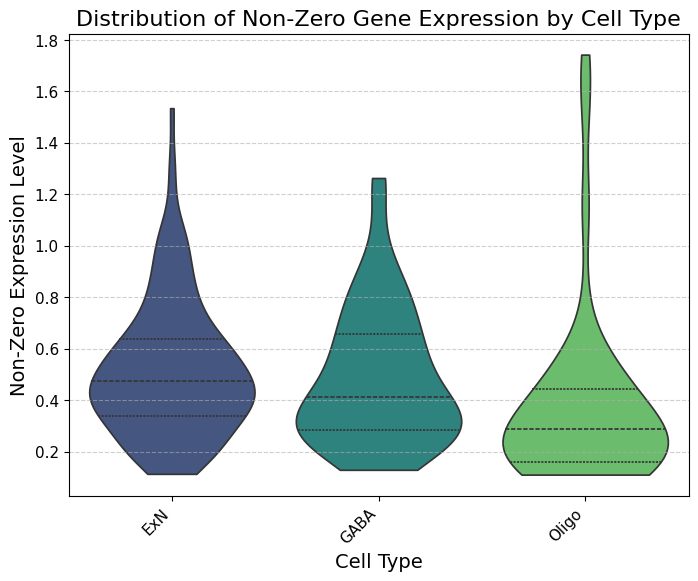

In [49]:
print("\nGenerating violin plot...")
plt.figure(figsize=(8, 6))

# Determine the order for plotting (use the sorted list of cell_types)
plot_order = ['ExN', 'GABA','Oligo']

# Create violin plot using seaborn
ax = sns.violinplot(
    x='Cell Type',
    y='Expression',
    data=df_plot,
    order=plot_order,       # Ensure consistent order
    palette='viridis',      # Color palette
    hue='Cell Type',        # Color by cell type for legend mapping
    hue_order=plot_order,   # Match hue order to plot order
    inner='quartile',       # Show quartiles inside violins
    cut=0,                  # Prevent violins extending beyond data range
)

plt.title('Distribution of Non-Zero Gene Expression by Cell Type', fontsize=16)
plt.xlabel('Cell Type', fontsize=14)
plt.ylabel('Non-Zero Expression Level', fontsize=14) # Clarify y-axis label
plt.xticks(rotation=45, ha='right', fontsize=11) # Rotate labels for readability
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)

print("Displaying plot...")
plt.show()